In [1]:
# from anokas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model

import cv2
import platform
from tqdm import tqdm
import h5py
import yaml

Using TensorFlow backend.


In [2]:
image_size = (150,150)

df_train = pd.read_csv('../data/train_v2.csv')

In [3]:
with open('../label_maps.yml', 'r') as lablels:
    label_data = yaml.load(lablels)
inv_label_map = label_data['inv_label_map']
label_map = label_data['label_map']

In [4]:
x_train = []
y_train = []


for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('../data/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, image_size))
    y_train.append(targets)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.

100%|██████████| 40479/40479 [01:56<00:00, 346.16it/s]


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.15, random_state=42)
print(x_train.shape)
print(y_train.shape)

(34407, 150, 150, 3)
(34407, 17)


In [291]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_generator = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

this = train_generator.flow(x_train, y_train, batch_size=1)

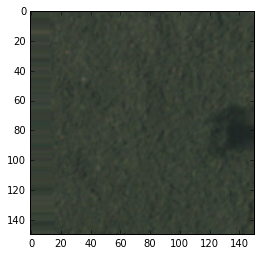

In [301]:
image = this.next()
image_to_plot = (image[0][0]*255).astype(np.uint8)
plt.imshow(cv2.cvtColor(image_to_plot, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
test_generator = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

this = train_generator.flow(x_train, y_train, batch_size=1)

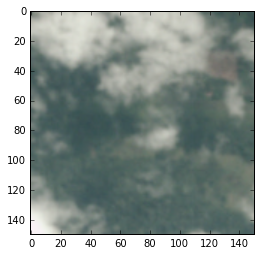

In [302]:
from matplotlib import pyplot as plt
%matplotlib inline
image_to_plot = (x_train[279]*255).astype(np.uint8)
plt.imshow(cv2.cvtColor(image_to_plot, cv2.COLOR_BGR2RGB))
plt.show()

In [303]:
import sys
sys.executable

'/Users/rhys/anaconda/envs/tensorflow_rl/bin/python'

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint


input_shape = (150,150,3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(17))
model.add(Activation('sigmoid'))

file_path = '../models/simple_cnn_weights_{epoch:02d}_{val_loss:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=0, save_best_only=False, 
                                save_weights_only=False, mode='auto', period=1)

model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy']
             )

In [305]:
#model.fit(x_train, y_train,
#          batch_size=128,
#          epochs=1,
#          verbose=1,
#          validation_data=(x_valid, y_valid),
#         callbacks = [model_checkpoint])

batch_size = 128

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / batch_size, epochs=1, validation_data=(x_valid, y_valid),
                    callbacks = [model_checkpoint], verbose=1)

Epoch 1/1
1/1 [==============================] - 55s - loss: 0.2243 - acc: 0.9182 - val_loss: 0.2049 - val_acc: 0.9198


In [ ]:
from sklearn.metrics import fbeta_score

p_valid = model.predict(x_valid, batch_size=128)
print(fbeta_score(y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))